In [1]:
import os
import time
from functools import partial

import numpy as np
from opt_einsum import contract

import jax
from jax import numpy as jnp
from jax import random
import optax

from src.QGAN import HaarSampleGeneration, QGAN
from src.distance_jax import naturalDistance

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [2]:
def cluster0Gen(n, N_train, scale, seed):
    # generate random quantum states close to |0...0>
    remains = (random.normal(random.PRNGKey(seed), shape=(N_train,2**n-1)) 
                + 1j*random.normal(random.PRNGKey(seed+1), shape=(N_train,2**n-1)))
    states = jnp.hstack((np.ones((N_train,1)), scale*remains))
    states /= jnp.tile(jnp.linalg.norm(states, axis=1).reshape((1, N_train)), (2**n, 1)).T
    return states.astype(jnp.complex64)

# Training

In [3]:
def training_generation(model, inputs, params_g, params_c, epochs):
    '''
    training of generator in QGAN
    Inputs:
        model: QGAN model
        inputs: input states of generators
        params_g: parameters of generator
        params_c: parameters of classifier
        epochs: training epochs
    '''
    loss_hist = [] # record of training history
    
    # set optimizer and learning rate decay
    optimizer = optax.adam(learning_rate = 0.0005)
    opt_state = optimizer.init(params_g)

    def loss_func_gen(params_g, inputs, params_c):
        states_gen = model.dataGenerate(inputs, params_g)
        zs = model.classCircuit_vmap(states_gen, params_c)
        # convert to the probability that determined as real data
        prob_real = (1. + jnp.real(zs))/2.
        return -jnp.mean(prob_real)

    loss_func_gen_vg = jax.jit(jax.value_and_grad(loss_func_gen))
    #@partial(jax.jit, static_argnums=(2, ))
    def update(params_g, inputs, params_c, opt_state):
        loss_value, grads = loss_func_gen_vg(params_g, inputs, params_c)
        updates, new_opt_state = optimizer.update(grads, opt_state, params_g)
        new_params_g = optax.apply_updates(params_g, updates)

        return new_params_g, new_opt_state, loss_value

    t0 = time.time()
    for step in range(epochs):
        params_g, opt_state, loss_value = update(params_g, inputs, params_c, opt_state)
        
        if step % 100 == 0:
            print("Step {}, loss: {:.7f}, time elapsed: {:.4f} seconds".format(step, loss_value, time.time() - t0))
        
        loss_hist.append(loss_value) # record the current loss

    return params_g, params_c, loss_hist


def training_classification(model, inputs, data_true, params_g, params_c, epochs):
    '''
    training of generator in QGAN
    Inputs:
        model: QGAN model
        inputs: input states of generators
        data_true: the true data
        params_g: parameters of generator
        params_c: parameters of classifier
        epochs: training epochs
    '''
    loss_hist = [] # record of training history

    # set optimizer and learning rate decay
    optimizer = optax.adam(learning_rate = 0.0005)
    opt_state = optimizer.init(params_c)

    def loss_func_class(params_c, inputs, data_true, params_g):
        states_gen = model.dataGenerate(inputs, params_g)
        zs_gen = model.classCircuit_vmap(states_gen, params_c)
        zs_true = model.classCircuit_vmap(data_true, params_c)
        # convert to the probability that determined as real data on fake data
        prob_real_fake = (1. + jnp.real(zs_gen))/2.
        # convert to the probability that determined as real data on real data
        prob_real_real = (1 + jnp.real(zs_true))/2
        return jnp.mean(prob_real_fake - prob_real_real)

    loss_func_class_vg = jax.jit(jax.value_and_grad(loss_func_class))
    #@partial(jax.jit, static_argnums=(2, ))
    def update(params_c, inputs, data_true, params_g, opt_state):
        loss_value, grads = loss_func_class_vg(params_c, inputs, data_true, params_g)
        updates, new_opt_state = optimizer.update(grads, opt_state, params_c)
        new_params_c = optax.apply_updates(params_c, updates)

        return new_params_c, new_opt_state, loss_value

    t0 = time.time()
    for step in range(epochs):
        np.random.seed()
        indices = np.random.choice(data_true.shape[0], size=inputs.shape[0], replace=False)

        params_c, opt_state, loss_value = update(params_c, inputs, data_true[indices], 
                                                 params_g, opt_state)
        
        if step % 100 == 0:
            print("Step {}, loss: {:.7f}, time elapsed: {:.4f} seconds".format(step, loss_value, time.time() - t0))
        
        loss_hist.append(loss_value) # record the current loss

    return params_g, params_c, loss_hist

In [4]:
def benchmarkProbs(model, inputs, data_true, params_g, params_c):
    '''
    benchmark function for discriminator and classifier on the probability
    '''
    states_gen = model.dataGenerate(inputs, params_g)
    zs_gen = model.classCircuit_vmap(states_gen, params_c)
    np.random.seed()
    indices = np.random.choice(data_true.shape[0], size=inputs.shape[0], replace=False)
    zs_true = model.classCircuit_vmap(data_true[indices], params_c)

    prob_real_real = jnp.mean((1. + zs_true)/2.) # real as real
    prob_real_fake = jnp.mean((1. + zs_gen)/2.) # fake as real
    return prob_real_real, prob_real_fake

In [5]:
n = 2 # data qubits
na = 1 # ancilla qubits
Lg = 120 # layer of generation circuit
Lc = 16 # layer of classifier circuit
Ndata = 100
epochs_c = 2001
epochs_g = 6001
cycles = 5 # the cycles of adversarial game

# create input data for generation circuit and true data
inputs = HaarSampleGeneration(Ndata, n, 42)
data_true = cluster0Gen(n, 10*Ndata, 0.06, seed=12)

model = QGAN(n=n, na=na, Lg=Lg, Lc=Lc)
loss_class = np.zeros((cycles, epochs_c))
loss_gen = np.zeros((cycles, epochs_g))
for cy in range(cycles):
    # initialize parameters
    key = random.PRNGKey(42)
    params_g = random.normal(key, shape=(2*(n+na)*Lg, ))
    params_c = random.normal(key, shape=(2*n*Lc, ))

    # training classifier holding generator fixed
    params_g, params_c, loss_hist1 = training_classification(model, inputs, data_true, 
                                                            params_g, params_c, epochs_c)
    loss_class[cy] = loss_hist1
    prob_rr, prob_rf = benchmarkProbs(model, inputs, data_true, params_g, params_c)
    print('cycle=%d, discriminator, Prob(real classified as real)=%s, Prob(fake classified as real)=%s'
          %(cy+1, prob_rr, prob_rf))

    # training generator holding classier fixed
    params_g, params_c, loss_hist2 = training_generation(model, inputs, params_g, params_c, 
                                                        epochs_g)
    loss_gen[cy] = loss_hist2
    prob_rr, prob_rf = benchmarkProbs(model, inputs, data_true, params_g, params_c)
    print('cycle=%d, generator, Prob(fake classified as real)=%s, Discriminator cost=%s'
          %(cy+1, prob_rf, prob_rf-prob_rr))

np.save('data/qgan/QGANcluster0paramsGen_n2na1Lg120Lc16_cy%d.npy'%cy, params_g)
np.save('data/qgan/QGANcluster0paramsCla_n2na1Lg120Lc16_cy%d.npy'%cy, params_c)
np.save('data/qgan/QGANcluster0lossGen_n2na1Lg120Lc16_cy%d.npy'%cy, loss_gen)
np.save('data/qgan/QGANcluster0lossCla_n2na1Lg120Lc16_cy%d.npy'%cy, loss_class)

Step 0, loss: -0.1956369, time elapsed: 140.9701 seconds
Step 100, loss: -0.5154527, time elapsed: 141.3436 seconds
Step 200, loss: -0.6036160, time elapsed: 141.6774 seconds
Step 300, loss: -0.6194443, time elapsed: 142.0206 seconds
Step 400, loss: -0.6246474, time elapsed: 142.3872 seconds
Step 500, loss: -0.6240035, time elapsed: 142.7625 seconds
Step 600, loss: -0.6269845, time elapsed: 143.1048 seconds
Step 700, loss: -0.6218306, time elapsed: 143.4373 seconds
Step 800, loss: -0.6271203, time elapsed: 143.8587 seconds
Step 900, loss: -0.6259945, time elapsed: 144.2067 seconds
Step 1000, loss: -0.6267234, time elapsed: 144.5606 seconds
Step 1100, loss: -0.6274898, time elapsed: 144.9127 seconds
Step 1200, loss: -0.6262673, time elapsed: 145.2808 seconds
Step 1300, loss: -0.6257665, time elapsed: 145.6427 seconds
Step 1400, loss: -0.6266737, time elapsed: 145.9586 seconds
Step 1500, loss: -0.6253694, time elapsed: 146.2776 seconds
Step 1600, loss: -0.6265900, time elapsed: 146.6418 

# Performance

## generate training and testing data

In [6]:
n = 2 # data qubits
na = 1 # ancilla qubits
Lg = 120 # layer of generation circuit
Lc = 16
Ndata = 100

params_g = np.load('data/qgan/QGANcluster0paramsGen_n2na1Lg120Lc16_cy5.npy')

inputs_tr = HaarSampleGeneration(Ndata, n, 42)
inputs_te = HaarSampleGeneration(Ndata, n, 50)
model = QGAN(n, na, Lg, Lc)
states_gen_tr = model.dataGenerate(inputs_tr, params_g)
states_gen_te = model.dataGenerate(inputs_te, params_g)

np.save('data/qgan/QGANcluster0traingen_n2na1Lg120Lc16.npy', states_gen_tr)
np.save('data/qgan/QGANcluster0testgen_n2na1Lg120Lc16.npy', states_gen_te)

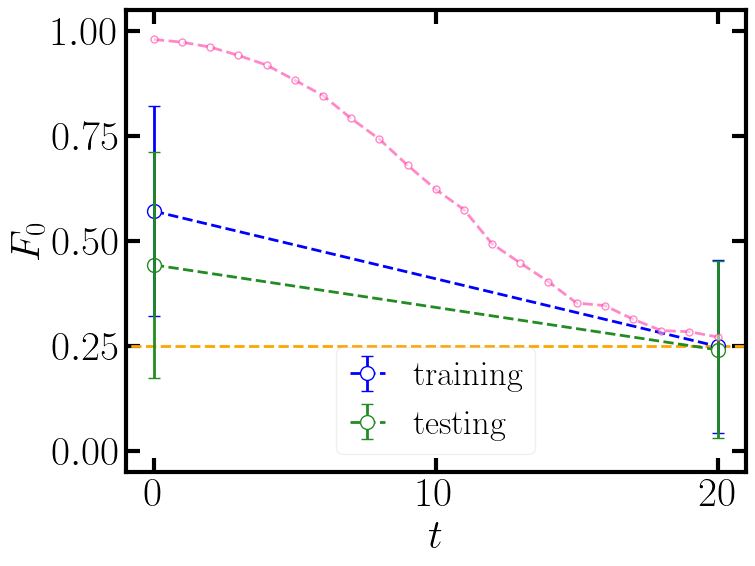

In [7]:
Ndata = 100
n = 2
states_gen_tr = np.load('data/qgan/QGANcluster0traingen_n2na1Lg120Lc16.npy')
states_gen_te = np.load('data/qgan/QGANcluster0testgen_n2na1Lg120Lc16.npy')
inputs_tr = HaarSampleGeneration(Ndata, n, 42)
inputs_te = HaarSampleGeneration(Ndata, n, 50)

f0_tr_qgan = np.vstack((np.abs(states_gen_tr[:, 0])**2, np.abs(inputs_tr[:, 0])**2))
f0_te_qgan = np.vstack((np.abs(states_gen_te[:, 0])**2, np.abs(inputs_te[:, 0])**2))

F0_diff = np.abs(np.load('data/cluster/n2/cluster0Diff_n2T20_N1000.npy')[:,:,0])**2

fig, ax = plt.subplots(figsize=(8, 6))
T1 = 20
ax.errorbar([0, T1], np.mean(f0_tr_qgan, axis=1), yerr=np.std(f0_tr_qgan, axis=1), fmt='o--',
    lw=2, mfc='white', barsabove=True, markersize=10, c='b', capsize=4, zorder=5, label=r'$\rm training$')
ax.errorbar([0, T1], np.mean(f0_te_qgan,axis=1), yerr=np.std(f0_te_qgan, axis=1), fmt='o--',
    lw=2, mfc='white', barsabove=True, markersize=10, capsize=4, c='forestgreen', zorder=5, label=r'$\rm testing$')

ax.plot(np.arange(T1+1), np.mean(F0_diff, axis=1), 'o--', mfc='white',
    lw=2, markersize=5, c='deeppink', alpha=0.5, zorder=5)

ax.hlines(0.25, xmin=-5, xmax=25, lw=2, ls='--', color='orange')
ax.legend(fontsize=25, loc='lower center', handlelength=1, framealpha=0.3)
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_xlim(-1, 21)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(np.arange(3)*10)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)